In [1]:
import pandas as pd
import os
import numpy as np

In [95]:
pd.set_option('display.max_columns', None)

### Colunas importantes:
CO_IES: código único da IES

QT_INSCRITO_TOTAL: Quantidade total de inscritos

NU_ANO_CENSO: ano


In [ ]:
DATA_FOLTER = './data/censo/'

df_final = pd.DataFrame()
for filename in os.listdir(DATA_FOLTER):
    df = pd.read_csv(
        f"{DATA_FOLTER}/{filename}", sep=";", encoding="latin1"
    )

    df_ano = (
        df[["CO_IES", "QT_INSCRITO_TOTAL", "NU_ANO_CENSO"]]
        .groupby("CO_IES")
        .agg({"QT_INSCRITO_TOTAL": "sum", "NU_ANO_CENSO": "max"})
        .reset_index()
    )

    # compute
    tot_alunos = df_ano['QT_INSCRITO_TOTAL'].sum()
    mkt_share = df_ano['QT_INSCRITO_TOTAL'] / tot_alunos
    df_ano['mkt_share'] = mkt_share
    df_ano['hh'] = mkt_share ** 2
    df_ano['entropia_theil'] = mkt_share * np.abs(np.log(mkt_share))

    lim_sup_theil = np.log(len(df_ano))
    df_ano['entropia_theil_norm'] = mkt_share * np.abs(np.log(mkt_share))

    df_final = pd.concat([df_final, df_ano])

In [3]:
df_final[df_final['QT_INSCRITO_TOTAL'] > 0].sort_values('mkt_share').to_excel('medidas_de_concentracao_por_IES.xlsx', index=False)

# Análise por IES

In [4]:
import matplotlib.pyplot as plt 

In [5]:
df = pd.read_excel('medidas_de_concentracao_por_IES.xlsx')

In [100]:
def find_cr(n, ano):
    return (
        sum(
            df[df["NU_ANO_CENSO"] == ano].sort_values("mkt_share", ascending=False)[
                "mkt_share"
            ][:n]
        )
        * 100
    )

In [101]:
df_g = df.groupby("NU_ANO_CENSO").agg(
    {
        "CO_IES": "count",
        "QT_INSCRITO_TOTAL": "sum",
        "hh": "sum",
        "entropia_theil_norm": "sum",
    }
)
anos = df_g.index

cr4 = [find_cr(4, ano) for ano in anos]
cr8 = [find_cr(8, ano) for ano in anos]
hh = df_g["hh"].apply(lambda x: x * 10000)
entropia_norm = df_g["entropia_theil_norm"]
tot_alunos = df_g["QT_INSCRITO_TOTAL"]
qtde_ies = df_g["CO_IES"]

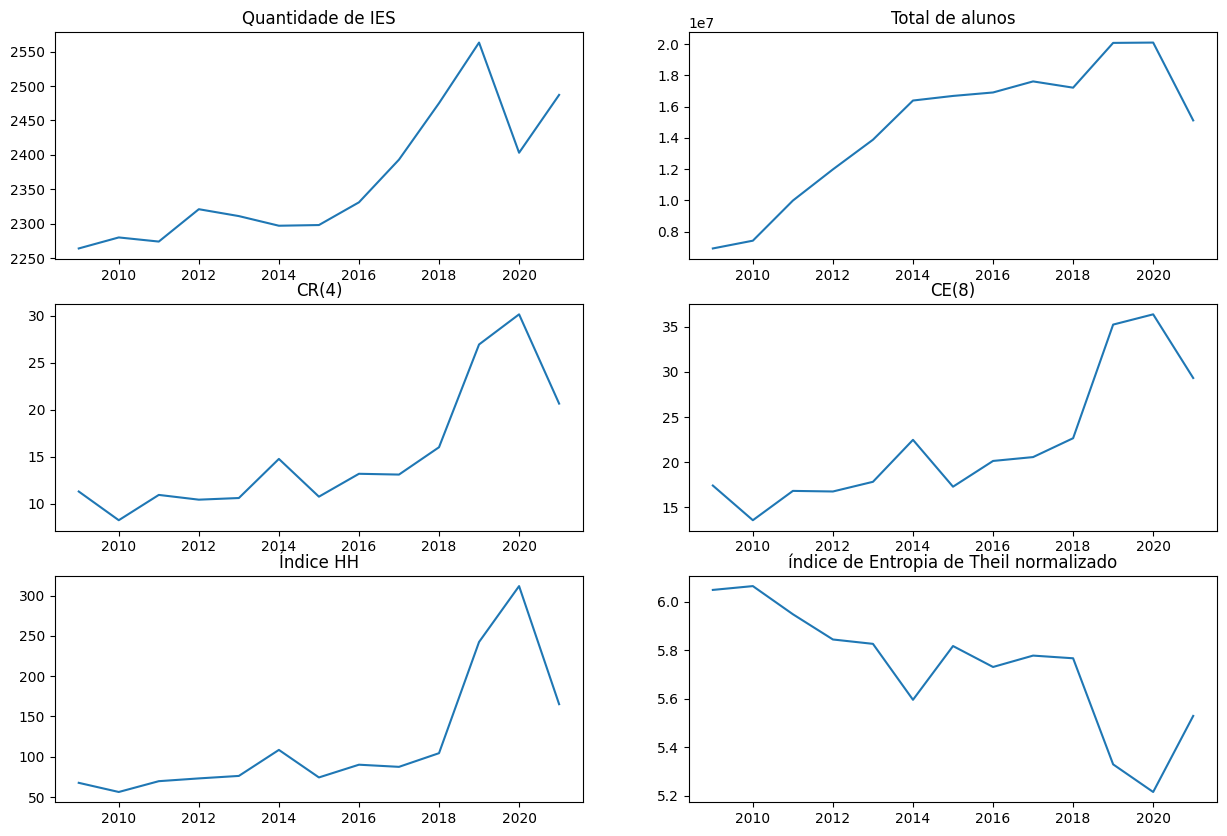

In [102]:
figure, axis = plt.subplots(3, 2, figsize=(15, 10))

axis[0, 0].plot(anos, qtde_ies)
axis[0, 0].set_title("Quantidade de IES")

axis[0, 1].plot(anos, tot_alunos)
axis[0, 1].set_title("Total de alunos")

axis[1, 0].plot(anos, cr4)
axis[1, 0].set_title("CR(4)")

axis[1, 1].plot(anos, cr8)
axis[1, 1].set_title("CE(8)")

axis[2, 0].plot(anos, hh.values)
axis[2, 0].set_title("Índice HH")

axis[2, 1].plot(anos, entropia_norm.values)
axis[2, 1].set_title("índice de Entropia de Theil normalizado")
plt.show()

# Análise por mantenedora

In [ ]:
import matplotlib.pyplot as plt 

In [47]:
df = pd.read_excel('medidas_de_concentracao_por_IES.xlsx')

df_fies = pd.read_excel('dados_fies_por_IES.xlsx')
df_fies['NU_ANO'] = [int(ano) for ano in df_fies['NU_ANO']]

In [48]:
df_merge = df[["CO_IES", "NU_ANO_CENSO", "QT_INSCRITO_TOTAL"]].merge(
    df_fies,
    left_on=["CO_IES", "NU_ANO_CENSO"],
    right_on=["CO_IES", "NU_ANO"],
    how="left",
)

# pegar até 2017 por conta da limitação dos dados do FIES
df_merge = df_merge[df_merge["NU_ANO_CENSO"] <= 2017].reset_index()

In [111]:
df_merge['cod_ies_or_mant'] = [co_mant if str(co_mant) != 'nan' else co_ies for co_ies, co_mant in zip(df_merge['CO_IES'], df_merge['CO_MANTENEDORA'])]

In [134]:
df_g = (
    df_merge.groupby(["cod_ies_or_mant", "NU_ANO_CENSO"])
    .agg(
        {
            "CO_IES": "count",
            "QT_INSCRITO_TOTAL": "sum",
            "tot_repasse": "sum",
            "tot_alunos": "sum",
        }
    )
    .reset_index()
    .rename(
        {
            "CO_IES": "tot_ies",
            "tot_alunos": "tot_alunos_fies",
            "QT_INSCRITO_TOTAL": "tot_alunos",
            "NU_ANO_CENSO": "ano",
        },
        axis=1,
    )
)

anos = df_g['ano'].unique()

df_final = pd.DataFrame()
for ano in anos:
    df_ano = df_g[df_g['ano'] == ano].reset_index(drop=True)
    tot_alunos = sum(df_ano['tot_alunos'])
    
    ies_or_mants = df_ano['cod_ies_or_mant'].unique()
    for idx, ies_or_mant in enumerate(df_ano['cod_ies_or_mant']):
        mkt_share = df_ano.loc[idx, 'tot_alunos'] / tot_alunos * 100
        df_ano.loc[idx, 'mkt_share'] = mkt_share
        df_ano.loc[idx, 'hh'] = mkt_share ** 2
        df_ano.loc[idx, 'theil'] = mkt_share * np.abs(np.log(mkt_share))
        df_ano.loc[idx, 'theil_norm'] = mkt_share * np.abs(np.log(mkt_share)) / np.log(len(df_ano))

    df_final = pd.concat([df_final, df_ano])

In [135]:
df_final_g = df_final.groupby("ano").agg(
    {
        "cod_ies_or_mant": "count",
        "tot_alunos": "sum",
        "mkt_share": "sum",
        "hh": "sum",
        "theil_norm": "sum",
    }
)

In [139]:
def find_cr(n, ano, df):
    return (
        sum(
            df[df["ano"] == ano].sort_values("mkt_share", ascending=False)["mkt_share"][
                :n
            ]
        )
    )


cr4 = [find_cr(4, ano, df_final) for ano in anos]
cr8 = [find_cr(8, ano, df_final) for ano in anos]
hh = df_final_g["hh"]
entropia_norm = df_final_g["theil_norm"]
tot_alunos = df_final_g["tot_alunos"]
qtde_ies = df_final_g["cod_ies_or_mant"]

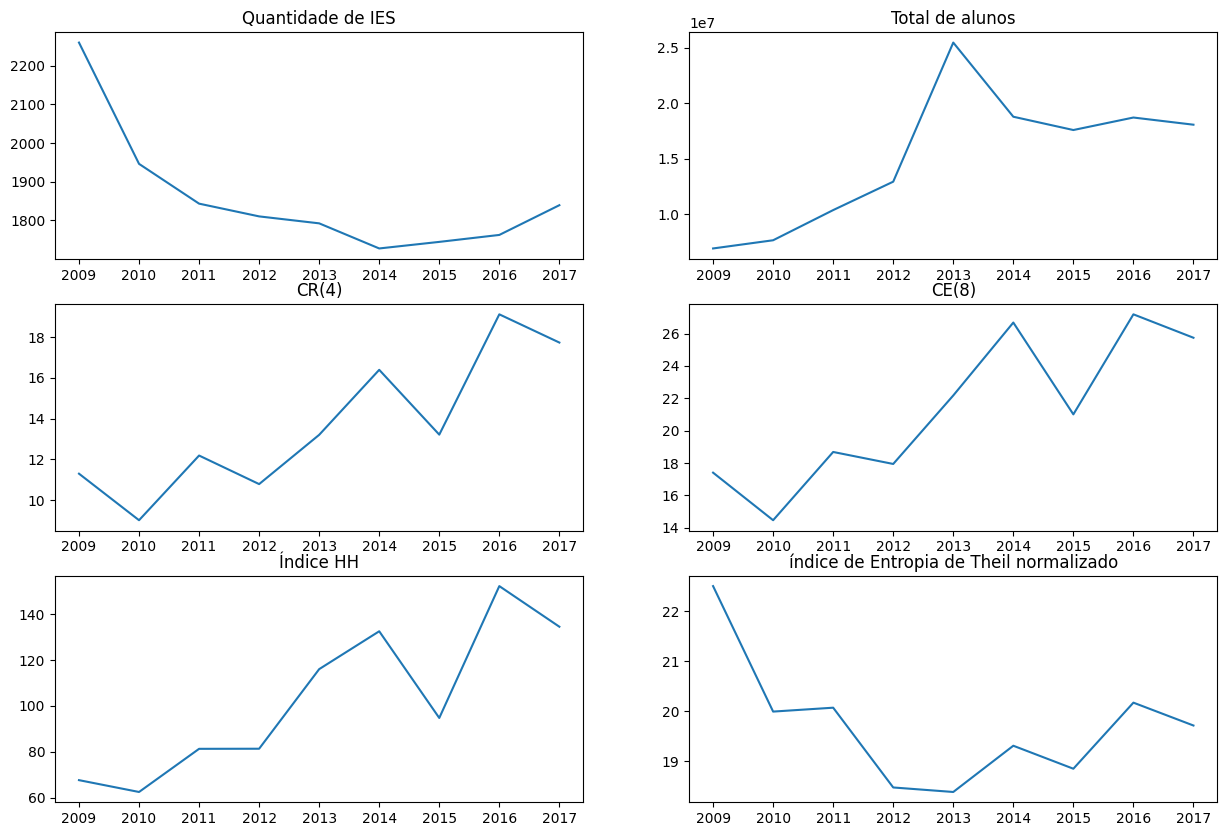

In [140]:
figure, axis = plt.subplots(3, 2, figsize=(15, 10))

axis[0, 0].plot(anos, qtde_ies)
axis[0, 0].set_title("Quantidade de IES")

axis[0, 1].plot(anos, tot_alunos)
axis[0, 1].set_title("Total de alunos")

axis[1, 0].plot(anos, cr4)
axis[1, 0].set_title("CR(4)")

axis[1, 1].plot(anos, cr8)
axis[1, 1].set_title("CE(8)")

axis[2, 0].plot(anos, hh.values)
axis[2, 0].set_title("Índice HH")

axis[2, 1].plot(anos, entropia_norm.values)
axis[2, 1].set_title("índice de Entropia de Theil normalizado")
plt.show()